# Visualization Code

This will plot 2D and 3D EOF's at different depth layers. 

# Initialize Workspace

## Load packages

In [1]:
import numpy as np
from numpy import meshgrid
import scipy.io as sc
import os
from pprint import pprint
import matplotlib.pyplot as plt
from numpy import linspace
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib
import math
import time
import csv
import netCDF4 as nc 
from netCDF4 import Dataset as ds

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import ticker



from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top2 = cm.get_cmap('winter')
bottom2 = cm.get_cmap('hot_r')
newcolors2 = np.vstack((top2(np.linspace(0, 1, 128)),   # I want all of the winter cmap and it will only explain 100 points
                    bottom2(np.linspace(.1, .9, 128)))) # I dont want the extremes of hot cmap but it will explain 128 points
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')

import warnings
warnings.filterwarnings("ignore")


C:\Users\bubby\AppData\Local\Temp\ipykernel_11576\223941139.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top2 = cm.get_cmap('winter')
C:\Users\bubby\AppData\Local\Temp\ipykernel_11576\223941139.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom2 = cm.get_cmap('hot_r')


## Define Functions

In [2]:

def set_directory():
    global data_directory
    path = 'F:/GLORYS/'
    if not os.path.exists(path):
        data_directory = '/Volumes/Elements/GLORYS'
    else:
        data_directory = path
    return

#################################################################################################################
#################################################################################################################

# Function creates a folder if it doesnt already exist
# Input:
#         - folder_path: string with the path name to folder

def create_folder(folder_path):
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")
set_directory()

#################################################################################################################
#################################################################################################################
# Function compute volume weights based on latitude and depthe values. Although longitude values are not
# in the equation the length of the longitude array is necessary for building 3D volume weight array 
# Input:
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
# Output: 
#         - area_weight: 3D array 
def vol_weight(depths, lon, lat):
    xx, yy = meshgrid(lon, lat)
    tot_depth = len(depths)
    
    # area weight for lattitude values
    area_w = np.cos(yy*math.pi/180)
    if lat[-1] == 90.0:
        area_w[-1,:] = 0.0
    # area weights for depth
    area_weight = []
    for i in range(tot_depth):
        if i == 0:
            area_weight.append(np.sqrt(depths[0] * area_w)) # first depth thickness
        else:
            area_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w))
    # Turning weights into one array
    area_weight = np.array(area_weight)
    return area_weight

#################################################################################################################
#################################################################################################################

# Function formats longitude to get rid of degree symbols
# Input:
#         - longitude: numeric corresponding to parallel


def format_longitude(longitude):
    if not 0 <= longitude <= 360:
        return "Invalid longitude. Must be between 0 and 360 degrees."
    
    if longitude == 0:
        hemisphere = ''
        degrees = longitude
    elif longitude < 180:
        hemisphere = 'E'
        degrees = longitude
    elif longitude == 180:
        hemisphere = ''
        degrees = longitude
    else:
        hemisphere = 'W'
        degrees = 360 - longitude

    return f"{degrees:.0f}{hemisphere}"


#################################################################################################################
#################################################################################################################

# Function formats latitude to get rid of degree symbols
# Input:
#         - latitude: numeric corresponding to meridian


def format_latitude(latitude):
    if not -90 <= latitude <= 90:
        return "Invalid latitude. Must be between -90 and 90 degrees."
    
    if latitude > 0:
        hemisphere = "N"    
    elif latitude == 0:
        hemisphere = ""
    else: 
        hemisphere = 'S'
    
    degrees = abs(latitude)

    return f"{degrees:.0f}{hemisphere}"



## Define Variables

In [3]:
month = 'Winter Avg'


fn     = 'Anomalies/Jan/Jan.anom.mon.1993.nc'
fn     = os.path.join(data_directory, fn)
fn     =  ds(fn,'r')
lat    = fn.variables['lat'][:].data    # read in latitude
lon    = fn.variables['lon'][:].data   # read in longitude
depths = fn.variables['Z'][:].data       # read in depth
fn.close()


####### SELECT REGION ########
'''
region = "Pacific"


# for the entire Pacific
lat_start = 720
lat_end   = 1801
lon_start = 1440
lon_end   = 3600

# Not sure which one to do
#depth_end = len(depths)
depth_end = 32
'''

region = "Global"

# Global
lat_start = 0
lat_end   = len(lat)
lon_start = 0
lon_end   = len(lon)
depth_end = len(depths)


############################



EOF_directory  = os.path.join(data_directory, '2D EOFs/' + month + "/" +region + "/")
create_folder(EOF_directory)
anomalies_directory = os.path.join(data_directory, 'Anomalies/Winter Avg' )




years  = np.linspace(1994, 2021,28, dtype="int")
cut_lat = lat[lat_start:lat_end]
cut_lon = lon[lon_start:lon_end]
cut_depths = depths[:depth_end]

Folder 'F:/GLORYS/2D EOFs/Winter Avg/Global/' already exists.


# EOF At Depths

## Read in Files

### Read in Data

In [8]:

# EOF Mode of Interest

mode = 3






#################################################################
#### 2D 
#################################################################
# Read in files
fn      = 'EOF_'+str(mode)+'.nc'
fn      = os.path.join(EOF_directory, fn)     # join with EOF path
EOF_ncfile = ds(fn, 'r')
EOF = EOF_ncfile.variables['EOF']
EOF = EOF[:].filled()
EOF_ncfile.close()

# Calculate
area_weight = vol_weight(cut_depths, cut_lon, cut_lat)
EOF = EOF/area_weight  # remember to div by area weight 



# Correct negatively oriented layers by mode

if region == 'Pacific':
    # For Pacific
    noiseLayers1 = [8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 28, 31]
    noiseLayers2 = [0, 4, 5, 9, 11, 14, 15, 16, 18, 20, 23, 25, 26, 27, 29, 30, 31]
    print('pacific')
elif region == "Global":
    noiseLayers1 = [8, 9, 13, 14, 15, 17, 19, 20, 24, 25, 29, 30, 34, 36, 37, 38, 39, 40, 42, 44, 46, 47]
    noiseLayers2 = [3, 4, 5, 6, 8, 11, 12, 13, 15, 17, 18, 20, 21, 22, 24, 26, 28, 30, 31, 33, 35, 41, 45, 46, 47]
    noiseLayers3 = [0, 2, 3, 4, 7, 8, 11, 18, 23, 26, 29, 30, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48]   # Correct
    #noiseLayers3 = [1, 5, 6, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 31, 32, 33, 35, 36, 46, 47]  # Incorrect
    #print(noiseLayers1)

for i in range(depth_end):
    if (i in noiseLayers1) and (mode == 1):
        EOF[i, :, :] = -EOF[i, :, :]
        print("Mode1:")
    elif (i in noiseLayers2) and (mode == 2):
        EOF[i, :, :] = -EOF[i, :, :]
        EOF = -EOF
        print("mode2")
    elif (i in noiseLayers3) and (mode == 3):
        EOF[i, :, :] = -EOF[i, :, :]
        #EOF = -EOF
        print("mode3")



#################################################################
#### 3D 
#################################################################

fn   = 'EOF_'+str(mode)+'.nc'
fn   = os.path.join("F:/GLORYS/cut_EOFs/Winter Avg/Global/", fn)       # join with EOF path
EOF_ncfile = ds(fn, 'r')
EOF3D = EOF_ncfile.variables['EOF']
EOF3D = EOF3D[:].filled()
EOF_ncfile.close()

area_weight_3D = vol_weight(cut_depths, cut_lon, cut_lat)
EOF3D = EOF3D/area_weight  # remember to div by area weight 

if mode == 1:
    EOF3D = -EOF3D
    depth_list = [0, 18, 24, 27, 29] ## Mode 1
    adjustY = 0.054
elif mode == 2:
    EOF3D = -EOF3D
    depth_list = [0, 18, 24, 26, 28] ## Mode 2
elif mode == 3:
    EOF3D = EOF3D
    #EOF3D = -EOF3D
    depth_list = [0, 16, 21, 22, 27]         ## Mode 3
    adjustY = 0.068

#################################################################
#### Formatting Variable Initialization 
#################################################################


# Plot Formatting
title_sz = 19
label_sz = title_sz-3



#depth = depths[depth_ind]


mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3
mode3


In [17]:
# # mode = 2
# fn   = 'EOF_'+str(mode)+'.nc'
# fn   = os.path.join("F:/GLORYS/cut_EOFs/Winter Avg/Global/", fn)       # join with EOF path
# EOF_ncfile = ds(fn, 'r')
# EOF3D = EOF_ncfile.variables['EOF']
# EOF3D = EOF3D[:].filled()
# EOF_ncfile.close()

# area_weight_3D = vol_weight(cut_depths, cut_lon, cut_lat)
# EOF3D = EOF3D/area_weight  # remember to div by area weight 

# if mode == 1:
#     EOF3D = -EOF3D
# else:
#     EOF3D = -EOF3D


# print(fn)

depths[18]

55.76429

## SLider

In [15]:

clip2D = 0.0003
clip3D = 0.00009

from matplotlib import ticker
def format_longitude(longitude):
    if not 0 <= longitude <= 360:
        return "Invalid longitude. Must be between 0 and 360 degrees."
    
    if longitude <= 180:
        hemisphere = 'E'
        degrees = longitude
    else:
        hemisphere = 'W'
        degrees = 360 - longitude

    return f"{degrees:.0f}{hemisphere}"


def format_latitude(latitude):
    if not -90 <= latitude <= 90:
        return "Invalid latitude. Must be between -90 and 90 degrees."
    
    hemisphere = 'N' if latitude >= 0 else 'S'
    degrees = abs(latitude)

    return f"{degrees:.0f}{hemisphere}"





def f(depth_ind):
    depth = depths[depth_ind]
    
    
    
    #Plot first depth
    fig, ax = plt.subplots(figsize=(15., 10.)) 
    
    mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c')
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0],cut_lat[-1],20), 
                        fmt=format_latitude,
                        labels = [1,0,0,0], fontsize = label_sz)
    mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],30), 
                        fmt=format_longitude,
                        labels = [0,0,0,1], fontsize = label_sz)
    
    dat = EOF[depth_ind,:,:]
    
    dat = np.maximum(np.minimum(dat, clip2D), -clip2D) # climp min and max values
    norm = mpl.colors.Normalize(vmin=-clip2D, vmax=clip2D)
    plt.contourf(cut_lon, cut_lat,  dat, 20, cmap = newcmp2, norm = norm)
    
    if depth_ind == 0:
        plt.title(f"{month} EOF {mode} at Surface", size = title_sz)
    else:    
        plt.title(f"{month} EOF {mode} at {round(depth)}m", size = title_sz)
    
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
    sm.set_array([]) 
    cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .4)
    cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
    cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
    cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
    cbar.ax.tick_params(labelsize=15)    # set label size of ticks
    cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
    cbar.update_ticks()

    
    
    

interactive(f, depth_ind = (0,len(cut_depths)-1))

interactive(children=(IntSlider(value=24, description='depth_ind', max=49), Output()), _dom_classes=('widget-i…

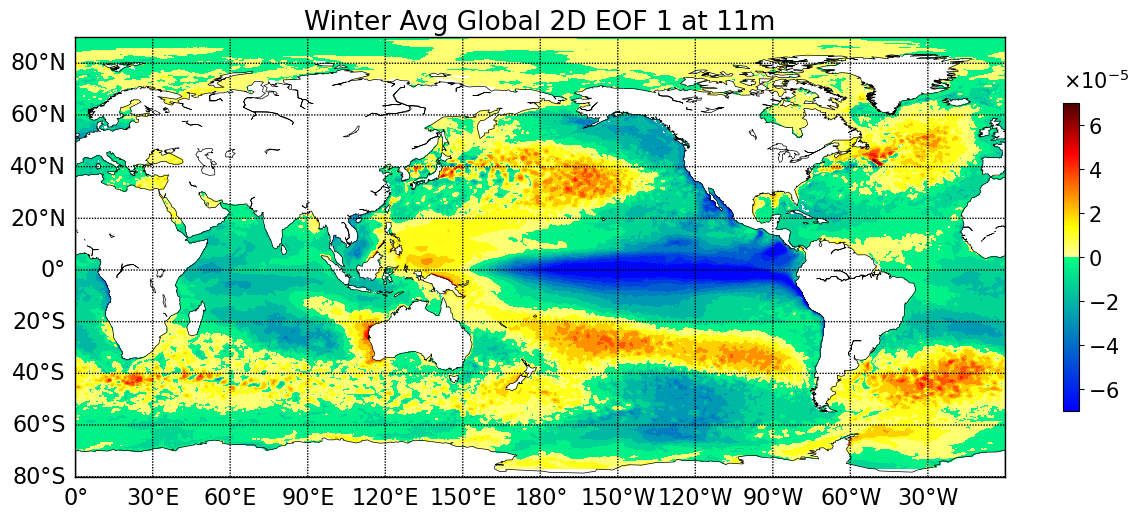

In [9]:
depth_ind = 8
depth = depths[depth_ind]         # For naming plot

clip2D = 0.00007        # Mode 1 17, 27 Clip
#clip2D = 0.000007       # Mode 1 Level 41 Clip

#Plot first depth
fig, ax = plt.subplots(figsize=(15., 10.)) 

mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0],cut_lat[-1],20), labels = [1,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],30), labels = [0,0,0,1], fontsize = label_sz)

dat = EOF[depth_ind,:,:]

dat = np.maximum(np.minimum(dat, clip2D), -clip2D) # climp min and max values
norm = mpl.colors.Normalize(vmin=-clip2D, vmax=clip2D)
plt.contourf(cut_lon, cut_lat,  dat, 20, cmap = newcmp2, norm = norm)

if depth_ind == 0:
    plt.title(f"{month} {region} 2D EOF {mode} at Surface", size = title_sz)
else:    
    plt.title(f"{month} {region} 2D EOF {mode} at {round(depth)}m", size = title_sz)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .4)
cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
cbar.ax.tick_params(labelsize=15)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()



saveName = "D:/SCIL/Paper Figs/" + region + "/DJF_" + region + "_depth" + str(depth_ind) + "_mode_" + str(mode) + "_2D"

#plt.savefig(saveName)

In [11]:

def f(depth_ind):
    depth = depths[depth_ind]

    
    #clip3D = np.nanmax(abs(dat)) # set min and max values
    clip3D = 0.00009
    #clip3D = .00007 # set min and max values
    dat3D = EOF3D[depth_ind,:,:]
    dat3D = np.maximum(np.minimum(dat3D, clip3D), -clip3D) # climp min and max values

    #Plot first depth
    fig, ax = plt.subplots(figsize=(18., 11.)) 
    #plt.figure(figsize=(15., 6.))

    mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c')
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0],cut_lat[-1],30), labels = [1,0,0,0], fontsize = label_sz)
    mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],60), labels = [0,0,0,1], fontsize = label_sz)

    norm = mpl.colors.Normalize(vmin=-clip3D, vmax=clip3D)
    ax.contourf(cut_lon, cut_lat,  dat3D, 20, cmap = newcmp2, norm= norm)

    if depth_ind == 0:
        plt.title(f"{month} EOF {mode} at Surface", size = title_sz)
    else:    
        plt.title(f"{month} EOF {mode} at {round(depth)}m", size = title_sz)
    
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
    sm.set_array([]) 
    #cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .97)
    cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .5)
    cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
    cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
    cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
    cbar.ax.tick_params(labelsize=15)    # set label size of ticks
    cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
    cbar.update_ticks()
interactive(f, depth_ind = (0,len(cut_depths)-1))




interactive(children=(IntSlider(value=24, description='depth_ind', max=49), Output()), _dom_classes=('widget-i…

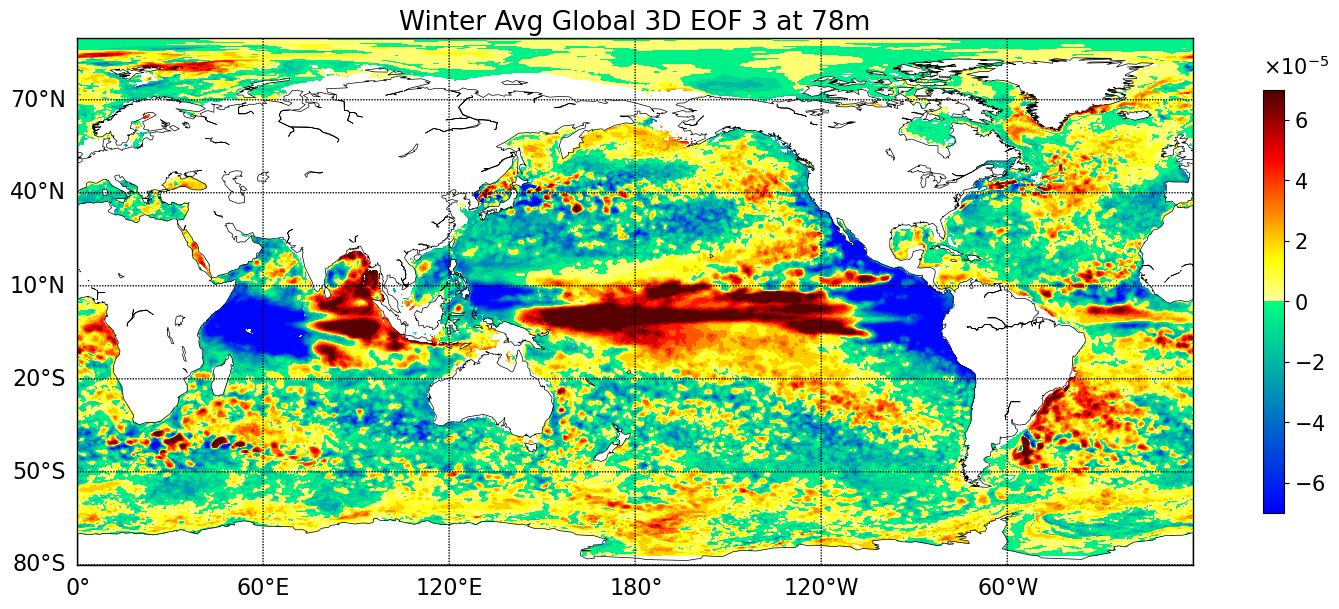

In [14]:
depth_ind = 20 # select depth layer


depth = depths[depth_ind]   # subsets depth layer from data  

dat3D = EOF3D[depth_ind,:,:]

#clip3D = .00007 # set min and max values
#clip3D = 0.000007
#clip3D = 0.0001
dat3D = np.maximum(np.minimum(dat3D, clip3D), -clip3D) # climp min and max values

#Plot first depth
fig, ax = plt.subplots(figsize=(18., 11.)) 
#plt.figure(figsize=(15., 6.))

mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(cut_lat[0],cut_lat[-1],30), labels = [1,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],60), labels = [0,0,0,1], fontsize = label_sz)

norm = mpl.colors.Normalize(vmin=-clip3D, vmax=clip3D)
ax.contourf(cut_lon, cut_lat,  dat3D, 20, cmap = newcmp2, norm= norm)

if depth_ind == 0:
    plt.title(f"{month} {region} 3D EOF {mode} at Surface", size = title_sz)
else:    
    plt.title(f"{month} {region} 3D EOF {mode} at {round(depth)}m", size = title_sz)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([]) 
#cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .97)
cbar = plt.colorbar(sm, ax = ax, format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .5)
cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
cbar.ax.tick_params(labelsize=15)    # set label size of ticks
cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
cbar.update_ticks()


saveName = "D:/SCIL/Paper Figs/" + region + "/DJF_" + region + "_depth" + str(depth_ind) + "_mode_" + str(mode) + "_3D"

plt.savefig(saveName)

## EOF Side by Side plots

## Save Fig

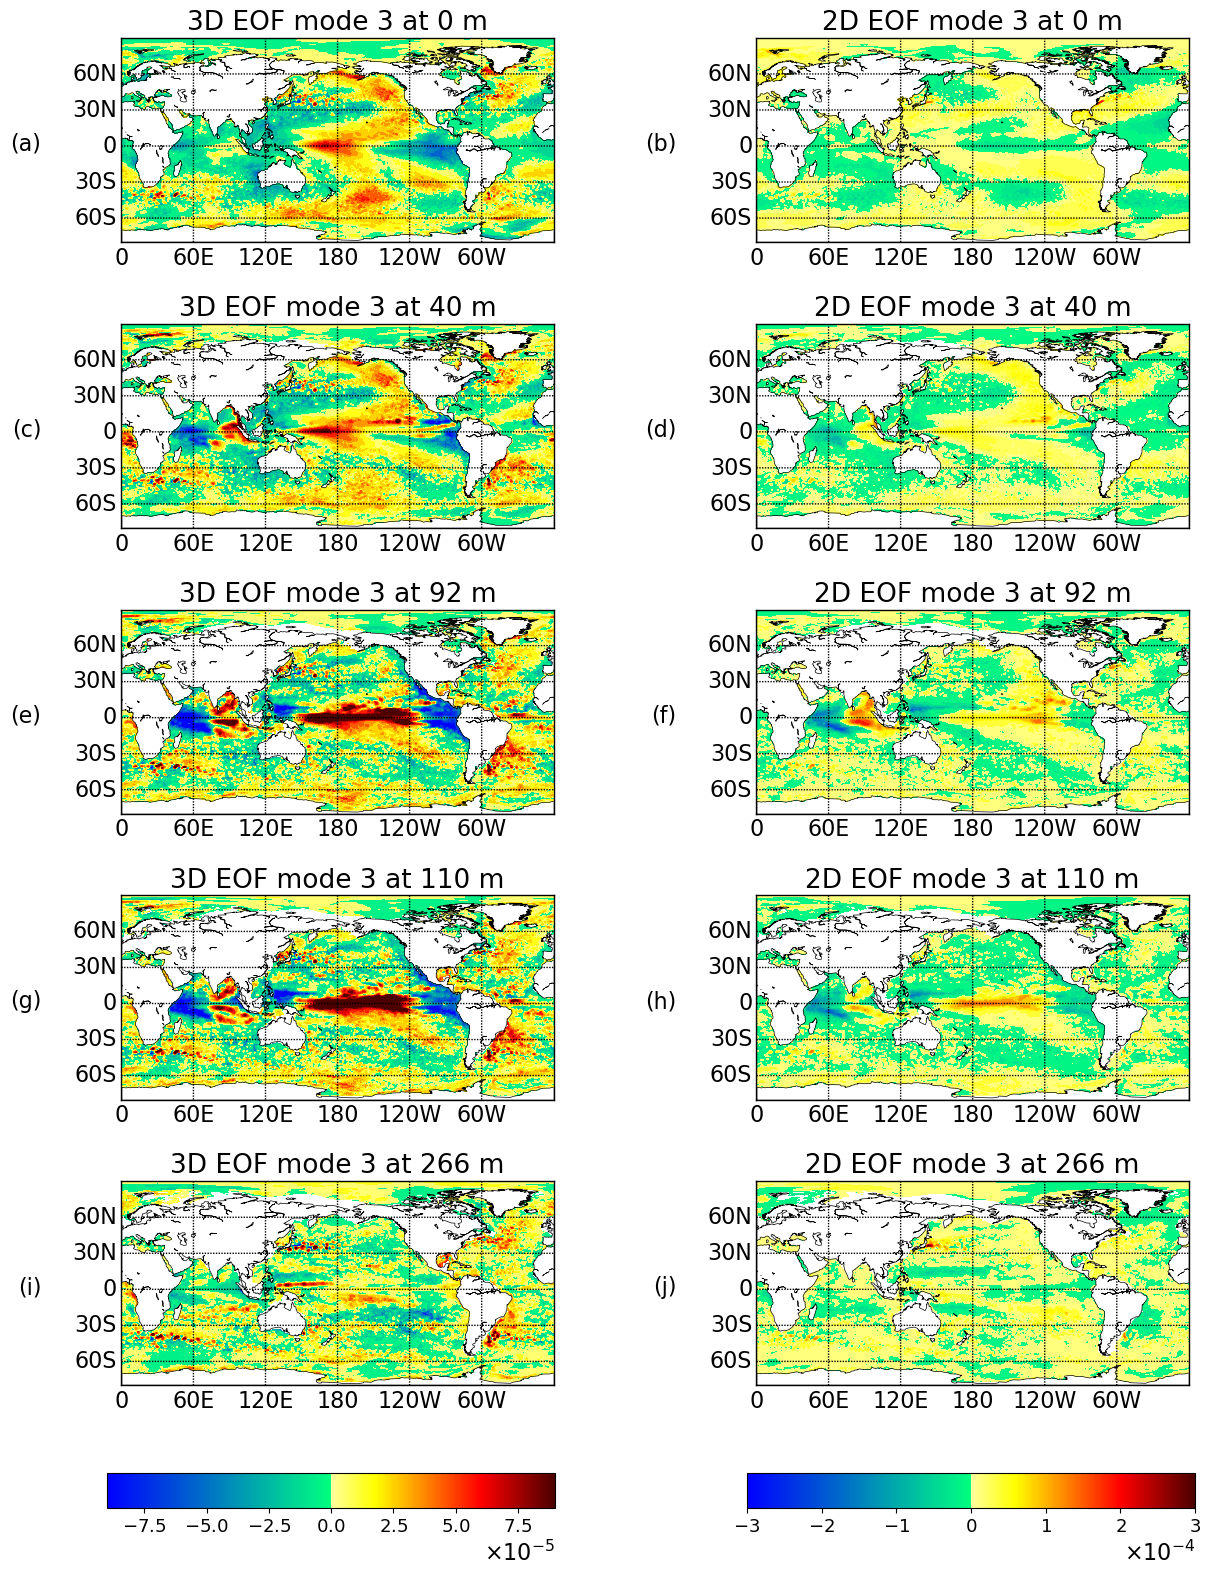

Figure saved to: D:/SCIL/Paper Figs/Global/eof3/EOF_panels_0_16_21_22_27.png


In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import numpy as np
import string

def plot_static_depth_panels(depth_indexes):
    clip2D = 0.0003
    clip3D = 0.00009
    n_panels = len(depth_indexes)

    fig, axes = plt.subplots(n_panels, 2, figsize=(16, 3.5 * n_panels))
    plt.subplots_adjust(wspace=0.05, hspace=0.4)

    norm3D = mpl.colors.Normalize(vmin=-clip3D, vmax=clip3D)
    norm2D = mpl.colors.Normalize(vmin=-clip2D, vmax=clip2D)

    # For labeling panels with (a), (b), ...
    panel_labels = list(string.ascii_lowercase)

    for i, dp in enumerate(depth_indexes):
        if dp >= len(depths):
            print(f"Depth index {dp} out of bounds — skipping.")
            continue

        str_depth = f"{dp:02d}"
        depth = depths[dp]

        dat3D = np.clip(EOF3D[dp, :, :], -clip3D, clip3D)
        dat2D = np.clip(EOF[dp, :, :], -clip2D, clip2D)

        ax3D = axes[i, 0]
        ax2D = axes[i, 1]

        # === 3D Plot ===
        map3D = Basemap(projection='cyl',
                        llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                        llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1],
                        resolution='c', ax=ax3D)
        map3D.drawcoastlines(color='black', linewidth=0.5)
        map3D.drawmapboundary()
        map3D.drawparallels(np.arange(cut_lat[0]+20, cut_lat[-1], 30),
                            labels=[1, 0, 0, 0], fmt=format_latitude, fontsize=label_sz)
        map3D.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 60),
                            labels=[0, 0, 0, 1], fmt=format_longitude, fontsize=label_sz)

        ax3D.contourf(cut_lon, cut_lat, dat3D, 20, cmap=newcmp2, norm=norm3D)
        ax3D.set_title(f"3D EOF mode {mode} at {round(depth)} m", size=title_sz)

        # === 2D Plot ===
        map2D = Basemap(projection='cyl',
                        llcrnrlat=cut_lat[0], urcrnrlat=cut_lat[-1],
                        llcrnrlon=cut_lon[0], urcrnrlon=cut_lon[-1],
                        resolution='c', ax=ax2D)
        map2D.drawcoastlines(color='black', linewidth=0.5)
        map2D.drawmapboundary()
        map2D.drawparallels(np.arange(cut_lat[0]+20, cut_lat[-1], 30),
                            labels=[1, 0, 0, 0], fmt=format_latitude, fontsize=label_sz)
        map2D.drawmeridians(np.arange(cut_lon[0], cut_lon[-1], 60),
                            labels=[0, 0, 0, 1], fmt=format_longitude, fontsize=label_sz)

        ax2D.contourf(cut_lon, cut_lat, dat2D, 20, cmap=newcmp2, norm=norm2D)
        ax2D.set_title(f"2D EOF mode {mode} at {round(depth)} m", size=title_sz)

        # === Panel Labels Outside Plots ===
        # Get position of current axes in figure coordinates
        for j, ax in enumerate([ax3D, ax2D]):
            label = f"({panel_labels[i * 2 + j]})"
            bbox = ax.get_position()
            # Place label to the left of the y-axis tick labels
            fig.text(bbox.x0 - 0.05, bbox.y1 - 0.054, label,
                     fontsize=label_sz, va='top', ha='right')

    # === Shared Colorbars (Bottom of Columns) ===
    cbar_ax3D = fig.add_axes([0.17, 0.04, 0.28, 0.02])  # [left, bottom, width, height]
    sm3D = mpl.cm.ScalarMappable(norm=norm3D, cmap=newcmp2)
    sm3D.set_array([])
    cbar3D = fig.colorbar(sm3D, cax=cbar_ax3D, orientation='horizontal',
                          format=mpl.ticker.ScalarFormatter(useMathText=True))
    cbar3D.ax.tick_params(labelsize=13)
    cbar3D.ax.xaxis.get_offset_text().set_fontsize(label_sz)
    cbar3D.formatter.set_powerlimits((0, 0))
    cbar3D.update_ticks()
    #cbar3D.set_label("3D EOF amplitude", fontsize=12)

    cbar_ax2D = fig.add_axes([0.57, 0.04, 0.28, 0.02])
    sm2D = mpl.cm.ScalarMappable(norm=norm2D, cmap=newcmp2)
    sm2D.set_array([])
    cbar2D = fig.colorbar(sm2D, cax=cbar_ax2D, orientation='horizontal',
                          format=mpl.ticker.ScalarFormatter(useMathText=True))
    cbar2D.ax.tick_params(labelsize=13)
    cbar2D.ax.xaxis.get_offset_text().set_fontsize(label_sz)
    cbar2D.formatter.set_powerlimits((0, 0))
    cbar2D.update_ticks()
    #cbar2D.set_label("2D EOF amplitude", fontsize=12)

    # Save figure to PNG
    output_path = f"D:/SCIL/Paper Figs/{region}/eof{mode}/EOF_panels_{'_'.join(map(str, depth_indexes))}.png" 
    plt.savefig(output_path, bbox_inches='tight', dpi=700)
    plt.show()
    print(f"Figure saved to: {output_path}")



# === Call the function with your depth indexes ===

plot_static_depth_panels(depth_list)


## Side by side SLider

In [5]:

def f(dp):
    
    
    
        
    clip2D = 0.0003
    clip3D = 0.00009
    
    
    depth = depths[dp]   # subsets depth layer from data  
    
    
    ####################################################
    ## 3D
    ####################################################
    
    # Load EOF data into new variable
    dat3D = EOF3D[dp,:,:]
    dat3D = np.maximum(np.minimum(dat3D, clip3D), -clip3D) # climp min and max values
    
    # Fig dimensions
    dim = np.array([19, 9])
    
    dim = dim*1.5
    
    
    #Plot first depth
    fig, ax = plt.subplots(1, 2, 
                           figsize=(dim[0], dim[1])
                          ) 
    
    plt.subplots_adjust(wspace=0.01)
    
    mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c', ax = ax[0])
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0]+20,cut_lat[-1],30), labels = [1,0,0,0], fmt=format_latitude, fontsize = label_sz)
    mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],60), labels = [0,0,0,1], fmt=format_longitude, fontsize = label_sz)
    
    norm = mpl.colors.Normalize(vmin=-clip3D, vmax=clip3D)
    ax[0].contourf(cut_lon, cut_lat,  dat3D, 20, cmap = newcmp2, norm= norm)
    
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
    sm.set_array([]) 
    cbar = plt.colorbar(sm, ax = ax[0], format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .4)
    cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
    cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
    cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
    cbar.ax.tick_params(labelsize=15)    # set label size of ticks
    cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
    cbar.update_ticks()
    
    
    ####################################################
    ## 2D
    ####################################################
    
    mymap = Basemap(projection='cyl',llcrnrlat=cut_lat[0],urcrnrlat=cut_lat[-1],llcrnrlon=cut_lon[0],urcrnrlon=cut_lon[-1],resolution='c', ax = ax[1])
    mymap.drawcoastlines(color='black', linewidth=.5)
    mymap.drawmapboundary()
    mymap.drawparallels(np.arange(cut_lat[0]+20,cut_lat[-1],30), labels = [1,0,0,0], fmt=format_latitude, fontsize = label_sz)
    mymap.drawmeridians(np.arange(cut_lon[0],cut_lon[-1],60), labels = [0,0,0,1], fmt=format_longitude, fontsize = label_sz)
    
    dat = EOF[dp,:,:]
    
    dat = np.maximum(np.minimum(dat, clip2D), -clip2D) # climp min and max values
    norm = mpl.colors.Normalize(vmin=-clip2D, vmax=clip2D)
    ax[1].contourf(cut_lon, cut_lat,  dat, 20, cmap = newcmp2, norm = norm)
    
    if dp == 0:
        ax[0].set_title(f"3D EOF mode {mode} at Surface", size = title_sz)
        ax[1].set_title(f"2D EOF mode {mode} at Surface", size = title_sz)
    else:    
        ax[1].set_title(f"2D EOF mode {mode} at {round(depth)}m", size = title_sz)
        ax[0].set_title(f"3D EOF mode {mode} at {round(depth)}m", size = title_sz)
    
    
    # Play with positioning
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
    sm.set_array([]) 
    cbar = plt.colorbar(sm, ax = ax[1], format = mpl.ticker.ScalarFormatter(useMathText=True), shrink = .4)
    cbar.ax.yaxis.get_offset_text().set_fontsize(15) # change exp size
    cbar.ax.yaxis.OFFSETTEXTPAD = 11           # moving exponent so it doesnt overlap with top of colorbar
    cbar.ax.yaxis.set_offset_position('left')  # setexponent so it is more left 
    cbar.ax.tick_params(labelsize=15)    # set label size of ticks
    cbar.formatter.set_powerlimits((0, 0))     # formatting scientific notation
    cbar.update_ticks()
    
        
    
    

interactive(f, dp = (0,len(cut_depths)-1))

interactive(children=(IntSlider(value=24, description='dp', max=49), Output()), _dom_classes=('widget-interact…

## 3D CUBE - Unused

### 2D 160E Plot

NameError: name 'exp_sz' is not defined

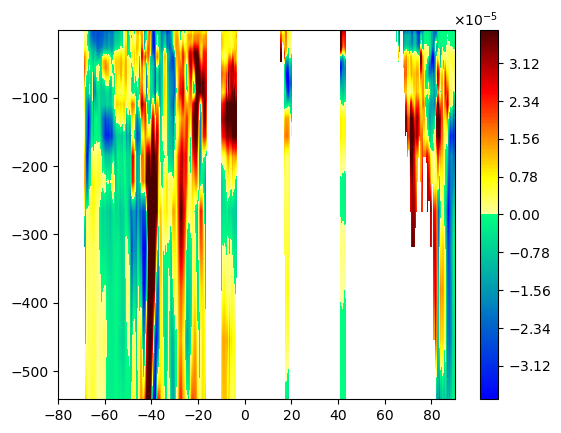

In [21]:
# depth_end = 32 # stop at this depth for the plot

# zlim =  clip
# lon_ind = 480                      # take cross section at 160 E

# #lon_ind = 1200                    # take cross section at 140 W

# Z = EOF[:depth_end, :, lon_ind]    # take cross section at 160 only first 13 depths

# surface = np.clip(Z, -zlim, zlim)    


# norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)

# plt.contourf(cut_lat[:], 0-np.array(cut_depths[:depth_end]), surface, 300, cmap = newcmp2)


# sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
# sm.set_array([])

# #cax = fig.add_axes([.93, 0.13, 0.02, 0.75]) #(left, bottom, width, height)


# cbar = plt.colorbar( format = mpl.ticker.ScalarFormatter(useMathText=True))
# cbar.ax.yaxis.get_offset_text().set_fontsize(exp_sz) # change exp size
# cbar.ax.yaxis.OFFSETTEXTPAD = 11 # moving exponent so it doesnt overlap
# cbar.ax.yaxis.set_offset_position('left') # set exponent position
# cbar.ax.tick_params(labelsize=label_sz) # set tick length
# cbar.formatter.set_powerlimits((0, 0))  # format ticks so they are scientific notation
# cbar.update_ticks()

# # labels formatting
# lon_name = convert_longitude(cut_lon[lon_ind])
# plt.title(f"DJF Avg 2D EOF {mode} at {lon_name}", size = title_sz)

# # X label formatting
# plt.xlabel("Latitude\n", size =label_sz+3)
# lat_name = []
# spacing = 5
# while len(cut_lat[0::12*spacing])> 8:
#     spacing += 2
# ind = 0
# for i in cut_lat[0::12*spacing]:
#   if i < 0:
#     lat_name.append(f"{abs(i)}$^\xb0$S")
#   else:
#     lat_name.append(f"{i}$^\xb0$N")
# plt.xticks(cut_lat[0::12*spacing], lat_name, fontsize = label_sz-2)

# # this is what will rename the depths correctly
# plt.ylabel(' Depth [m]', size =label_sz+5)
# step = 50                             # change this for smaller depth intervals
# y_labels = plt.yticks()
# dep_names = np.arange(0,-y_labels[0][0],step).astype(int)
# plt.yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = label_sz)
# ##########################################################################
# #Comment the next lines out for no contours
# num_contours = 12
# Z = clim[:depth_end, :, lon_ind] # plot at lat 10 south only first 13 depths
# CS = plt.contour(cut_lat[:], -np.array(cut_depths[:depth_end]), Z, colors='k', levels=num_contours)

# max_contour_level = 29 # Plot largest contour

# plt.clabel(plt.contour(cut_lat[:], -np.array(cut_depths[:depth_end]), Z, levels=[max_contour_level], colors='k'), inline=True, fontsize=label_sz)

# plt.clabel(CS, inline=True, fontsize=label_sz)
# ##########################################################################


# #savePath = f"D:/SCIL/Paper Figs/DJF Avg 2D EOF {mode} at 160E"


# #print(savePath)

# #plt.savefig(savePath)


# plt.show()

# Eigenvalue Comparisons

## Read in 2D Eigenvalues

In [8]:
import pandas as pd

fn = 'F:/GLORYS/2D EOFs/Winter Avg/' + region + '/Winter Avg_eigenvalues_eigenvectors.xlsx'


def read_eigenvalues_to_array(file_path):
    """
    Reads the 'Eigenvalue' column from all sheets in an Excel file and returns a NumPy array.

    Args:
        file_path (str): Path to the Excel file.

    Returns:
        np.ndarray: A 2D NumPy array with shape [x, n], where n = number of sheets and x = max number of eigenvalues.
    """
    xls = pd.ExcelFile(file_path)
    sheet_names = xls.sheet_names
    
    eigenvalue_lists = []
    
    for sheet in sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet)
        if 'Eigenvalue' in df.columns:
            eigenvalues = df['Eigenvalue'].dropna().tolist()
            eigenvalue_lists.append(eigenvalues)
        else:
            print(f"Warning: 'Eigenvalue' column not found in sheet '{sheet}'")
            eigenvalue_lists.append([])

    # Determine the maximum length
    max_length = max(len(e) for e in eigenvalue_lists)

    # Pad shorter lists with np.nan and convert to array
    padded_array = np.array([e + [np.nan]*(max_length - len(e)) for e in eigenvalue_lists]).T

    return padded_array


In [9]:
eigvals = read_eigenvalues_to_array(fn)

In [10]:
eigvals[:,1]

array([10773870.766247  ,  4045723.908973  ,  2793275.57408043,
        2722224.45145692,  2321260.67445448,  2116016.35948677,
        1757840.48035007,  1638574.41641936,  1522936.7531848 ,
        1422360.8288711 ,  1274148.30980052,  1199608.44521966,
        1093290.09022783,  1050688.5808114 ,   940658.77424877,
         934280.97460686,   905059.43483415,   825552.58304396,
         798135.45532393,   726692.95689116,   717318.79415036,
         700294.78631822,   683736.32920201,   675839.08392853,
         633592.79860666,   620229.24031241,   567291.62820156,
          19600.83324808])

## Read in 3D Eigenvalues

In [11]:
import pandas as pd

fn = 'F:/GLORYS/cut_EOFs/Winter Avg/' + region + '/Winter Avg_eigenvalues_eigenvectors.csv'

df = pd.read_csv(fn)

eigvals3d = df["Eigenvalue"].to_numpy()
eigvals3d

num_eval = np.arange(eigvals3d.shape[0])+1 # mode numbers
cumulative_eval = np.cumsum(eigvals3d) # compute cummulative variance
percVariance = (eigvals3d/cumulative_eval[-1])*100

df = pd.DataFrame(percVariance, columns = ["3D"])
df["Mode"] = num_eval


In [12]:
percVariance[0]

18.454140864160316

In [13]:


for i in range(depth_end):
    
    cumEval = np.cumsum(eigvals[:,i]) # compute cummulative variance
    pV = (eigvals[:,i]/cumEval[-1])*100

    colName = str(i)

    df[colName] = pV

newDF = df[:3]
newDF

,3D,Mode,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,18.454141,1,23.592443,23.689196,23.784201,23.876862,23.985110,24.122605,24.358906,24.621177,...,29.263947,33.791574,27.535050,21.329638,17.476666,16.483913,18.758457,24.876846,31.982493,NaN
1,11.569150,2,8.872421,8.895591,8.915637,8.926883,8.932443,8.933192,8.924915,8.912009,...,5.775675,6.187550,6.738940,7.026913,7.031517,7.595433,8.217879,10.518024,12.454334,NaN
2,5.171328,3,6.154371,6.141753,6.125716,6.112060,6.099488,6.087099,6.065227,6.049452,...,4.301129,4.407986,4.365392,4.466767,4.796341,5.459656,6.574529,6.997496,8.857677,NaN


In [24]:
newDF.iloc[:, 19:36]

,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,34.574631,34.845482,34.664552,34.343079,33.940005,32.730356,31.144940,30.250834,26.773175,20.085297,14.770516,12.611561,12.751761,14.015476,14.477316,13.300560,12.401463
1,8.010909,8.036158,8.313055,8.759359,9.221724,9.847593,10.642619,10.242128,9.755008,11.153572,11.240819,8.819180,6.615926,5.470090,5.239814,5.336165,5.200911
2,5.561217,6.081504,6.680930,7.158074,7.234052,6.878461,7.020346,6.666645,5.777826,5.519310,5.277066,5.406308,5.494805,5.299308,4.898043,4.837634,5.007723


In [11]:
newDF = df[:3]

for i in range(depth_end):

    colName = str(i)

    
    newDF[colName] = newDF[colName].sub(newDF["3D"])

#newDF["3D"] = 0

newDF = newDF.drop("3D", axis = 1)

print(newDF.abs().sum())

newDF.loc['Total'] = newDF.abs().sum()

newDF


Mode     6.000000
0        8.818075
1        8.879040
2        8.937962
3        9.005721
4        9.095837
5        9.220194
6        9.442900
7        9.702301
8       10.050444
9       10.500012
10      11.088146
11      11.824873
12      12.731351
13      13.828693
14      15.151677
15      16.802004
16      18.631656
17      20.068621
18      20.834508
19      20.976109
20      20.685476
21      19.896015
22      17.704905
23      15.466349
24      14.619033
25      10.739674
26       2.394716
27       4.117695
28       8.827531
29      10.979082
30      10.665706
31      10.579447
32      11.720260
33      12.584523
34      12.381171
35       7.668792
36       5.800545
37       6.085223
38       4.533674
39       5.882708
40      17.473481
41      21.482375
42      14.717056
43       8.122296
44       5.890096
45       6.232274
46       5.058789
47       9.299999
48      18.099884
49       0.000000
dtype: float64


,Mode,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,1.0,5.138303,5.235055,5.330060,5.422721,5.530969,5.668465,5.904765,6.167036,6.513897,...,10.809806,15.337433,9.080909,2.875497,-0.977475,-1.970228,0.304316,6.422705,13.528352,NaN
1,2.0,-2.696730,-2.673560,-2.653514,-2.642267,-2.636707,-2.635959,-2.644235,-2.657142,-2.679887,...,-5.793476,-5.381600,-4.830210,-4.542238,-4.537634,-3.973718,-3.351271,-1.051126,0.885183,NaN
2,3.0,0.983043,0.970425,0.954388,0.940732,0.928160,0.915771,0.893899,0.878124,0.856661,...,-0.870199,-0.763342,-0.805936,-0.704561,-0.374987,0.288327,1.403201,1.826168,3.686349,NaN
Total,6.0,8.818075,8.879040,8.937962,9.005721,9.095837,9.220194,9.442900,9.702301,10.050444,...,17.473481,21.482375,14.717056,8.122296,5.890096,6.232274,5.058789,9.299999,18.099884,0.0


In [12]:

two = newDF[:3].transpose()
two.columns = two.iloc[0]
new = two.drop("Mode")

new["Depth"] = range(1, len(new) + 1)

# new.melt(id_vars = ['Depth'], var_name = "Mode", value_name = "diff").groupby("Mode").plot(x = "diff", y = "Depth")
new

Mode,1.0,2.0,3.0,Depth
0,5.138303,-2.696730,0.983043,1
1,5.235055,-2.673560,0.970425,2
2,5.330060,-2.653514,0.954388,3
3,5.422721,-2.642267,0.940732,4
4,5.530969,-2.636707,0.928160,5
5,5.668465,-2.635959,0.915771,6
6,5.904765,-2.644235,0.893899,7
7,6.167036,-2.657142,0.878124,8
8,6.513897,-2.679887,0.856661,9
9,6.967536,-2.709847,0.822629,10


## Create Plotting Variables

In [13]:
#################################################################################################################
#################################################################################################################
# Function computes scree plot calculations by depth and saves EOF specific variance value to an array
# Input:
#         - mode: EOF # of choice
# Output:
#         - variance_array: np array of length(depths) with % variance explained by EOF 
# Important Variables: 
def eof_array(mode):
    mode = mode-1
    # Initialize zero array
    variance_array = []
    # For all depths
    for i in range(depth_end):
        # compute cummulative variance for depth layer
        cumulative_eval = np.cumsum(eigvals[:,i])
        # assign percentage variance for mode to array
        variance_array.append((eigvals[mode,i]/cumulative_eval[-1])*100)

    return(variance_array)



# Create % variance for first 
mode1 = eof_array(1)
mode2 = eof_array(2)
mode3 = eof_array(3)
# Sum of EOF 1 and 2
bothModes = np.add(mode1, mode2)

# Depth Layer
depthLayer = 0-np.array(cut_depths[:depth_end])

# Create % variance difference
mode1diff = new[1].to_numpy()
mode2diff = new[2].to_numpy()
mode3diff = new[3].to_numpy()



# Figure Text Formatting
title_sz = 24
label_sz = title_sz - 2
tick_sz = title_sz -2

# Line Colors

color21 = "r"
color22 = "black"
color23 = "b"

color31 = "hotpink"
color32 = "orange"
color33 = "green"

# Line Labels
label21 = "2D ρ₁"
label22 = "2D ρ₂"
label23 = "2D ρ₃"

label31 = "3D ρ₁"
label32 = "3D ρ₂"
label33 = "3D ρ₃"

# Horizontal Line Formatting
lineweight = "2"
dashLength=[1, 1]

## 2D Plots

### All depths

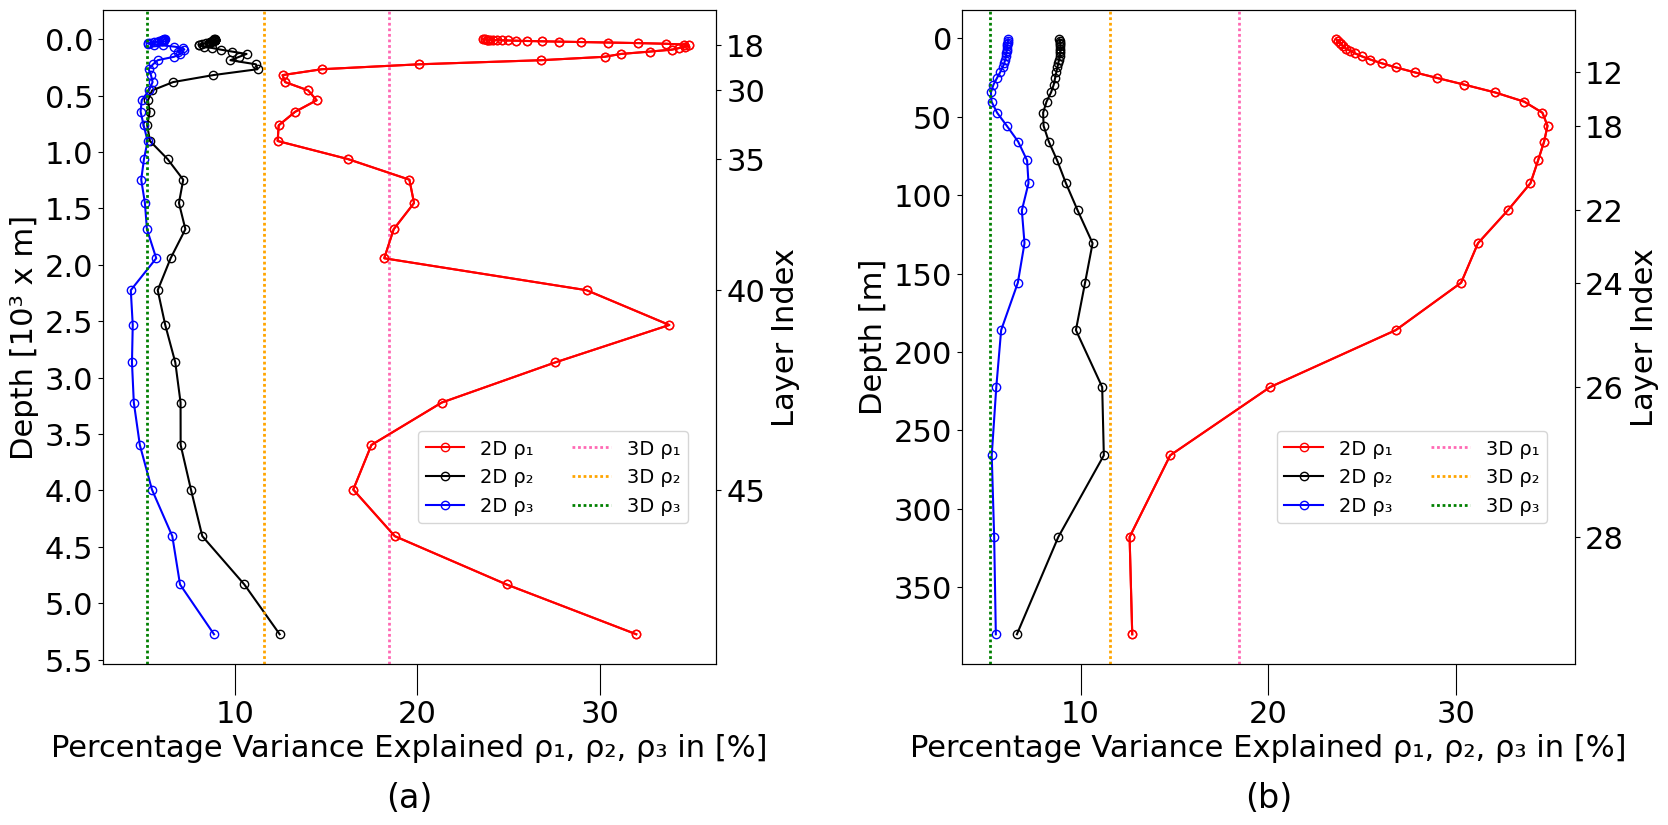

In [14]:

# Create Fig, Ax
fig, ax1 = plt.subplots(1, 2)

# Format 
fig.set_size_inches(19., 8.5)

plt.subplots_adjust(wspace=0.4)

#########################################################################
######## All Depths
#########################################################################


ax1[0].plot(mode1, depthLayer, color21, marker = 'o',markerfacecolor='none', label = label21)
ax1[0].plot(mode2, depthLayer, color22, marker = "o",markerfacecolor='none', label = label22)
ax1[0].plot(mode3, depthLayer, color23, marker = "o",markerfacecolor='none', label = label23)

# Format X axis
ax1[0].set_xlabel("Percentage Variance Explained ρ₁, ρ₂, ρ₃ in [%]", size = label_sz)
ax1[0].tick_params('x',size = tick_sz, labelsize = tick_sz)
#ax1.grid(axis = "x")
ax1[0].axvline(x = percVariance[0], color=color31, label=label31, lw = lineweight, dashes = dashLength)
ax1[0].axvline(x = percVariance[1], color=color32, label=label32, lw = lineweight, dashes = dashLength)
ax1[0].axvline(x = percVariance[2], color=color33, label=label33, lw = lineweight, dashes = dashLength)

# Format Left hand y axis
ax1[0].set_ylabel('Depth [10³ x m]', size =label_sz)
step = 500                            # change this for smaller depth intervals
y_labels = ax1[0].get_yticks()
dep_names = np.arange(0,-y_labels[0],step).astype(int)
dep_names_labels = (dep_names/1000).astype(str).tolist()
ax1[0].set_yticks(-dep_names, dep_names_labels, fontsize = tick_sz)
#ax1[0].axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')

# Create right hand y axis
ax2 = ax1[0].twinx()
ax2.plot(mode1, depthLayer, color21, marker = 'o', markerfacecolor='none')
dep_ind = np.arange(32).astype(str).tolist()



# Select based on depth of plot
#indexLabels = [0, 12, 17, 21, 24, 26, 28, 30]     # first 32
indexLabels = [18, 30, 35, 40, 45]

layerIndex = depthLayer[indexLabels]
ax2.set_yticks(layerIndex, indexLabels, fontsize = tick_sz)
ax2.set_ylabel('Layer Index', size =label_sz)
#ax2.grid(axis = "y")


#########################################################################
######## First 400m
#########################################################################

# ax1[1].plot(mode1[:30], depthLayer[:30,], color21, marker = 'o', label = label21)
# ax1[1].plot(mode2[:30], depthLayer[:30,], color22, marker = 'o', label = label22)
# ax1[1].plot(mode3[:30], depthLayer[:30,], color23, marker = 'o', label = label23)

ax1[1].plot(mode1[:30], depthLayer[:30], color21, marker='o', markerfacecolor='none', label=label21)
ax1[1].plot(mode2[:30], depthLayer[:30], color22, marker='o', markerfacecolor='none', label=label22)
ax1[1].plot(mode3[:30], depthLayer[:30], color23, marker='o', markerfacecolor='none', label=label23)



# Format X axis
ax1[1].set_xlabel("Percentage Variance Explained ρ₁, ρ₂, ρ₃ in [%]", size = label_sz)
ax1[1].tick_params('x',size = tick_sz, labelsize = tick_sz)
#ax1.grid(axis = "x")
ax1[1].axvline(x = percVariance[0], color=color31, label=label31, lw = lineweight, dashes = dashLength)
ax1[1].axvline(x = percVariance[1], color=color32, label=label32, lw = lineweight, dashes = dashLength)
ax1[1].axvline(x = percVariance[2], color=color33, label=label33, lw = lineweight, dashes = dashLength)

# Format Left hand y axis
ax1[1].set_ylabel('Depth [m]', size =label_sz)
step = 50                            # change this for smaller depth intervals
y_labels2 = ax1[1].get_yticks()
dep_names = np.arange(0,-y_labels2[0],step).astype(int)
ax1[1].set_yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = tick_sz)
#ax1[1].axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')

# Create right hand y axis
# Select layers of interest
indexLabels2 =[12, 18, 22, 24, 26, 28]
# Create right hand y-axis
ax3 = ax1[1].twinx()
ax3.set_ylim(ax1[1].get_ylim())
# Plot 
ax3.plot(mode1[:30], depthLayer[0:30], color=color21, marker='o', markerfacecolor='none', label=label21)
dep_ind = np.arange(32).astype(str).tolist()

# Create tick, grid, axis label
layerIndex2 = depthLayer[indexLabels2,]
ax3.set_yticks(layerIndex2, 
               indexLabels2, 
               fontsize = tick_sz)
ax3.set_ylabel('Layer Index', size =label_sz)
#ax3.grid(axis = "y")


#########################################################################
######## Legend and Title
#########################################################################
ax1[0].legend(ncol=2, bbox_to_anchor=(0.97, 0.2), loc='lower right', fontsize=tick_sz-8)
ax1[1].legend(ncol=2, bbox_to_anchor=(0.97, 0.2), loc='lower right', fontsize=tick_sz-8)

#ax1[0].legend(ncol = 2, bbox_to_anchor=(1, .35), fontsize = tick_sz-8)
#ax1[1].legend(ncol = 2, bbox_to_anchor=(1, .35), fontsize = tick_sz-8)


# #fig.suptitle("2D EOF Variance Explained at Depth Layer", size = title_sz)
# ax1[0].set_title("First 3 Eigenvalues for all depths: 5275 m", size = label_sz)
# ax1[1].set_title("First 3 Eigenvalues for top 400 m", size = label_sz)

ax1[0].text(0.5,-0.22, "(a)", size=title_sz, ha="center", 
         transform=ax1[0].transAxes)

ax1[1].text(0.5,-0.22, "(b)", size=title_sz, ha="center", 
         transform=ax1[1].transAxes)

#########################################################################
######## Save Figure
#########################################################################
saveName = 'D:/SCIL/Paper Figs/' + region + '/DJF_Variance_Explained_by_Depth_2_panel_v2.png'
#plt.savefig(saveName, dpi=300, bbox_inches='tight')
plt.show()

### First 500M

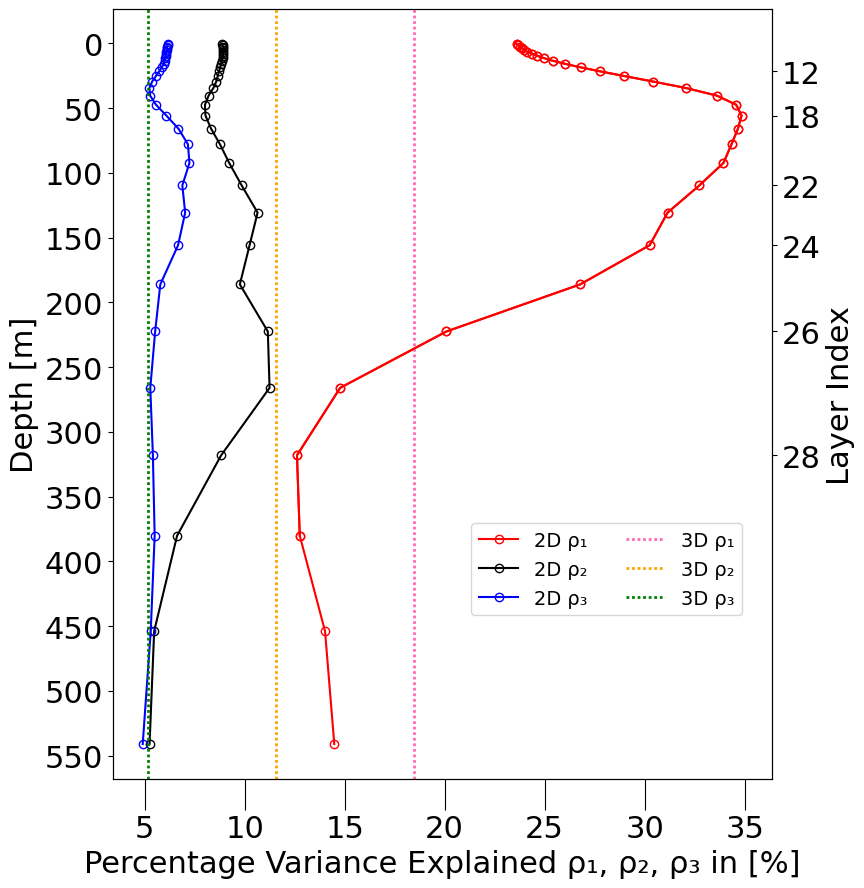

In [77]:

# Create Fig, Ax
fig, ax1 = plt.subplots(1, 1)

# Format 
fig.set_size_inches(8.5, 10)

#plt.subplots_adjust(wspace=0.4)

#########################################################################
######## First 400m
#########################################################################

# ax1[1].plot(mode1[:30], depthLayer[:30,], color21, marker = 'o', label = label21)
# ax1[1].plot(mode2[:30], depthLayer[:30,], color22, marker = 'o', label = label22)
# ax1[1].plot(mode3[:30], depthLayer[:30,], color23, marker = 'o', label = label23)

ax1.plot(mode1[:32], depthLayer[:32], color21, marker='o', markerfacecolor='none', label=label21)
ax1.plot(mode2[:32], depthLayer[:32], color22, marker='o', markerfacecolor='none', label=label22)
ax1.plot(mode3[:32], depthLayer[:32], color23, marker='o', markerfacecolor='none', label=label23)



# Format X axis
ax1.set_xlabel("Percentage Variance Explained ρ₁, ρ₂, ρ₃ in [%]", size = label_sz)
ax1.tick_params('x',size = tick_sz, labelsize = tick_sz)
#ax1.grid(axis = "x")
ax1.axvline(x = percVariance[0], color=color31, label=label31, lw = lineweight, dashes = dashLength)
ax1.axvline(x = percVariance[1], color=color32, label=label32, lw = lineweight, dashes = dashLength)
ax1.axvline(x = percVariance[2], color=color33, label=label33, lw = lineweight, dashes = dashLength)

# Format Left hand y axis
ax1.set_ylabel('Depth [m]', size =label_sz)
step = 50                            # change this for smaller depth intervals
y_labels2 = ax1.get_yticks()
dep_names = np.arange(0,-y_labels2[0],step).astype(int)
ax1.set_yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = tick_sz)
#ax1[1].axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')

# Create right hand y axis
# Select layers of interest
indexLabels2 =[12, 18, 22, 24, 26, 28]
# Create right hand y-axis
ax3 = ax1.twinx()
ax3.set_ylim(ax1.get_ylim())
# Plot 
ax3.plot(mode1[:30], depthLayer[0:30], color=color21, marker='o', markerfacecolor='none', label=label21)
dep_ind = np.arange(32).astype(str).tolist()

# Create tick, grid, axis label
layerIndex2 = depthLayer[indexLabels2,]
ax3.set_yticks(layerIndex2, 
               indexLabels2, 
               fontsize = tick_sz)
ax3.set_ylabel('Layer Index', size =label_sz)
#ax3.grid(axis = "y")


#########################################################################
######## Legend and Title
#########################################################################
ax1.legend(ncol=2, bbox_to_anchor=(0.97, 0.2), loc='lower right', fontsize=tick_sz-8)




#########################################################################
######## Save Figure
#########################################################################
saveName = 'D:/SCIL/Paper Figs/' + region + '/DJF_Variance_Explained_by_Depth_2_solo_v2.png'
plt.savefig(saveName, dpi=300, bbox_inches='tight')
plt.show()

## 3D vs 2D Plots

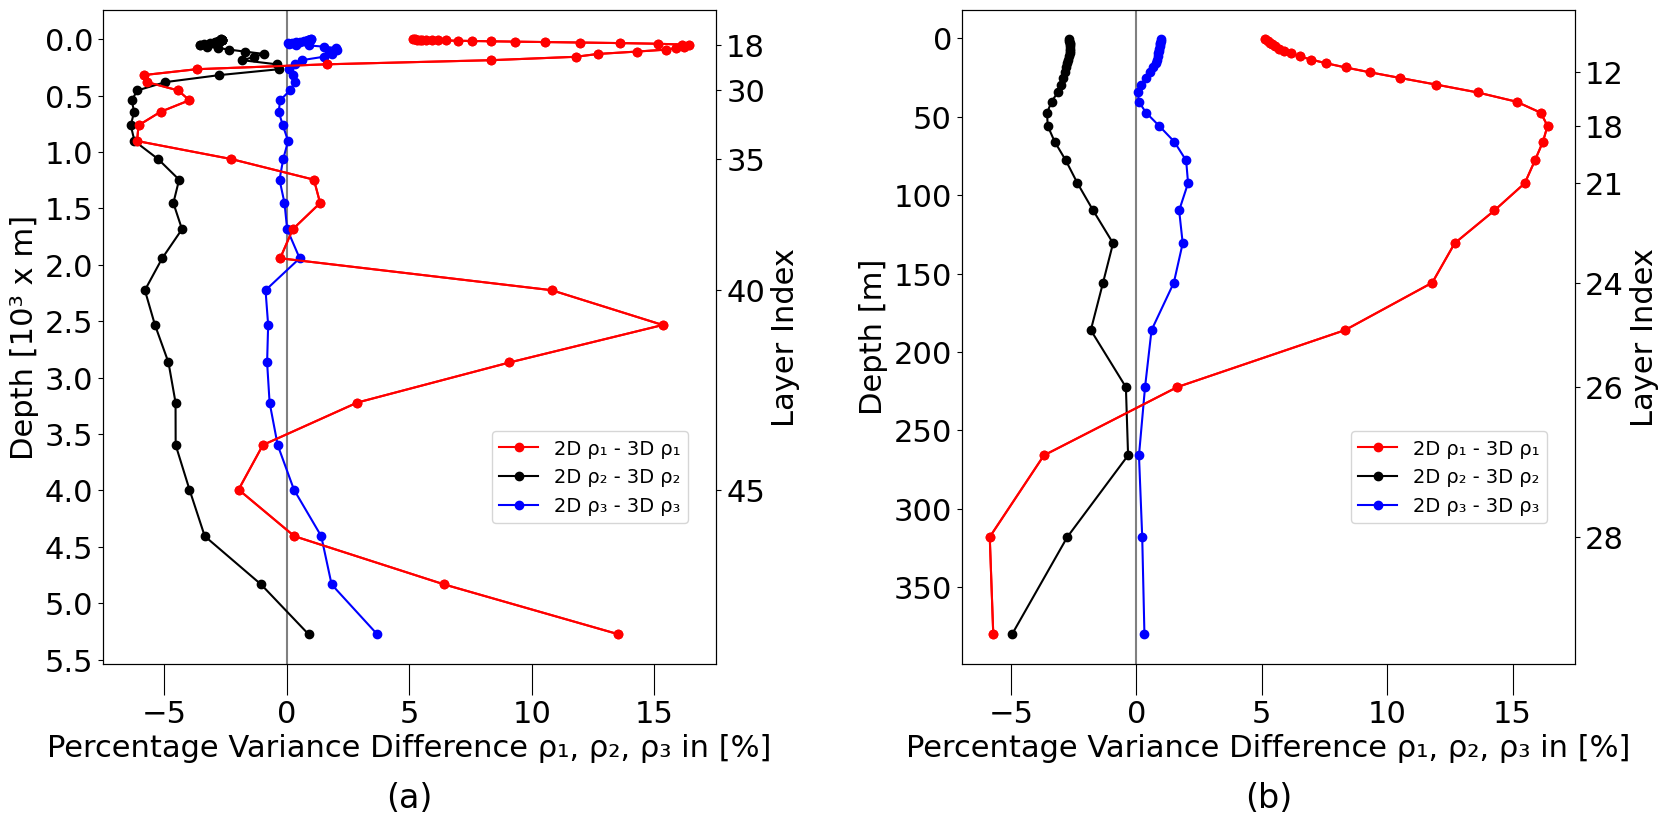

In [18]:

# Create Fig, Ax
fig, ax1 = plt.subplots(1, 2)

# Format 
fig.set_size_inches(19., 8.5)

plt.subplots_adjust(wspace=0.4)


#########################################################################
######## All Depths
#########################################################################
ax1[0].axvline(color = "grey")


ax1[0].plot(mode1diff, depthLayer, color21, marker = 'o', label = label21 + " - " + label31)
ax1[0].plot(mode2diff, depthLayer, color22, marker = "o", label = label22 + " - " + label32)
ax1[0].plot(mode3diff, depthLayer, color23, marker = "o", label = label23 + " - " + label33)

# Format X axis
ax1[0].set_xlabel('Percentage Variance Difference ρ₁, ρ₂, ρ₃ in [%]', size = label_sz)
ax1[0].tick_params('x',size = tick_sz, labelsize = tick_sz)
#ax1.grid(axis = "x")


# Format Left hand y axis
ax1[0].set_ylabel('Depth [10³ x m]', size =label_sz)
step = 500                            # change this for smaller depth intervals
y_labels = ax1[0].get_yticks()
dep_names = np.arange(0,-y_labels[0],step).astype(int)
dep_names_labels = (dep_names/1000).astype(str).tolist()
ax1[0].set_yticks(-dep_names, dep_names_labels, fontsize = tick_sz)
#ax1[0].axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')

# Create right hand y axis
ax2 = ax1[0].twinx()
ax2.plot(mode1diff, depthLayer, color21, marker = 'o')
dep_ind = np.arange(32).astype(str).tolist()

# Select based on depth of plot
indexLabels = [18, 30, 35, 40, 45]

layerIndex = depthLayer[indexLabels]
ax2.set_yticks(layerIndex, indexLabels, fontsize = tick_sz)
ax2.set_ylabel('Layer Index', size =label_sz)
#ax2.grid(axis = "y")

#########################################################################
######## First 400m
#########################################################################
ax1[1].axvline(color = "grey")
ax1[1].plot(mode1diff[:30], depthLayer[:30,], color21, marker = 'o', label = label21 + " - " + label31)
ax1[1].plot(mode2diff[:30], depthLayer[:30,], color22, marker = 'o', label = label22 + " - " + label32)
ax1[1].plot(mode3diff[:30], depthLayer[:30,], color23, marker = 'o', label = label23 + " - " + label33)

# Format X axis
ax1[1].set_xlabel('Percentage Variance Difference ρ₁, ρ₂, ρ₃ in [%]', size = label_sz)
ax1[1].tick_params('x',size = tick_sz, labelsize = tick_sz)


# Format Left hand y axis
ax1[1].set_ylabel('Depth [m]', size =label_sz)
step = 50                            # change this for smaller depth intervals
y_labels2 = ax1[1].get_yticks()
dep_names = np.arange(0,-y_labels2[0],step).astype(int)
ax1[1].set_yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = tick_sz)
#ax1[1].axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')


# Create right hand y axis
ax3 = ax1[1].twinx()
ax3.plot(mode1diff[:30], depthLayer[:30,], color21, marker = 'o',)
#ax3.set_ylim(ax1[1].get_ylim())
dep_ind = np.arange(32).astype(str).tolist()


# Select based on depth of plot
indexLabels2 = [12, 18, 21, 24, 26, 28]     # first 32
#indexLabels = [18, 30, 35, 40, 45]

layerIndex2 = depthLayer[indexLabels2]
ax3.set_yticks(layerIndex2, indexLabels2, fontsize = tick_sz)
ax3.set_ylabel('Layer Index', size =label_sz)
#ax3.grid(axis = "y")


#########################################################################
######## Legend and Title
#########################################################################
# ax1[0].legend(bbox_to_anchor=(1, .35), fontsize = tick_sz-2)
# ax1[1].legend(bbox_to_anchor=(1, .35), fontsize = tick_sz-2)


#fig.suptitle("Departure of 2D % Variance Explained from 3D", size = title_sz)
# # ax1[0].set_title("First 3 Eigenvalues for all depths", size = label_sz)
# # ax1[1].set_title("First 3 Eigenvalues for top 400m", size = label_sz)

# ax1[0].text(0.5,-0.2, "(a)", size=title_sz, ha="center", 
#          transform=ax1[0].transAxes)

# ax1[1].text(0.5,-0.2, "(b)", size=title_sz, ha="center", 
#          transform=ax1[1].transAxes)



ax1[0].legend(ncol=1, bbox_to_anchor=(0.97, 0.2), loc='lower right', fontsize=tick_sz-8)
ax1[1].legend(ncol=1, bbox_to_anchor=(0.97, 0.2), loc='lower right', fontsize=tick_sz-8)

ax1[0].text(0.5,-0.22, "(a)", size=title_sz, ha="center", 
         transform=ax1[0].transAxes)

ax1[1].text(0.5,-0.22, "(b)", size=title_sz, ha="center", 
         transform=ax1[1].transAxes)


saveName = 'D:/SCIL/Paper Figs/' + region + '/3D vs 2D Variance Difference at Depth Layer.png'
plt.savefig(saveName, dpi=300, bbox_inches='tight')
plt.show()

### All Depth Layers

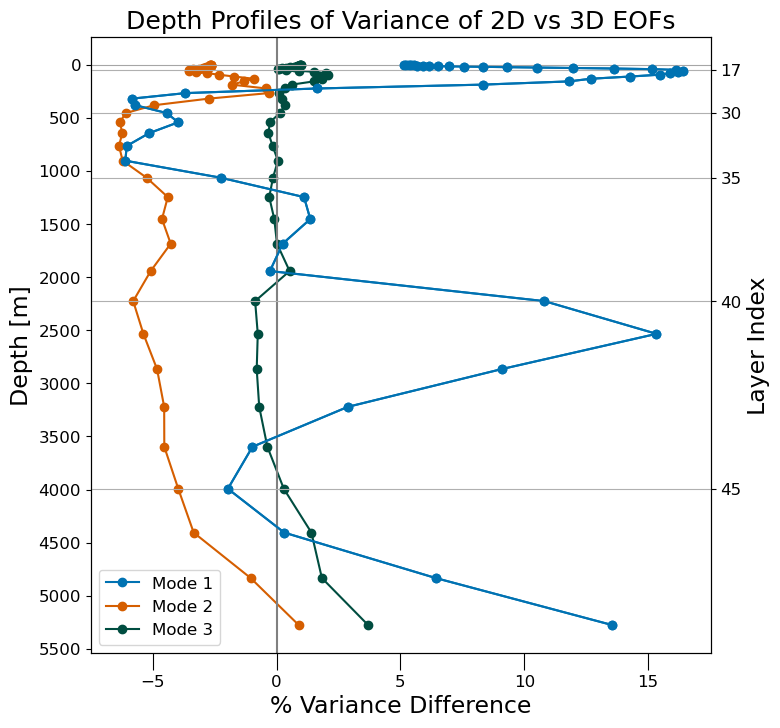

In [20]:


# Create Fig, Ax
fig, ax1 = plt.subplots()


# Format 
fig.set_size_inches(8., 8.)
title_sz = 18
label_sz = title_sz - 1
tick_sz = title_sz -6

p1 = plt.plot(mode1diff, depthLayer, '#0072B2', marker = 'o', label = 'Mode 1')

p2 = plt.plot(mode2diff, depthLayer, "#D55E00", marker = "o", label = "Mode 2")
p3 = plt.plot(mode3diff, depthLayer, "#004D40", marker = "o", label = "Mode 3")

# Format X axis
ax1.set_xlabel("% Variance Difference", size = label_sz)
ax1.tick_params('x',size = tick_sz, labelsize = tick_sz)
#ax1.grid(axis = "x")


# Format Left hand y axis
ax1.set_ylabel('Depth [m]', size =label_sz)
step = 500                            # change this for smaller depth intervals
y_labels = ax1.get_yticks()
dep_names = np.arange(0,-y_labels[0],step).astype(int)
ax1.set_yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = tick_sz)
ax1.axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')


# Legend and Title
plt.legend(fontsize = tick_sz, loc = "lower left") 
plt.title("Depth Profiles of Variance of 2D vs 3D EOFs", size = title_sz)
#plt.title("2D DJF % Variance by Depth", size = title_sz)
plt.axvline(color = "grey")

# Create right hand y axis
ax2 = ax1.twinx()
ax2.plot(mode1diff, depthLayer, '#0072B2', marker = 'o')
dep_ind = np.arange(32).astype(str).tolist()



# Select based on depth of plot
#indexLabels = [0, 12, 17, 21, 24, 26, 28, 30]     # first 32
indexLabels = [17, 30, 35, 40, 45]

layerIndex = depthLayer[indexLabels]
ax2.set_yticks(layerIndex, indexLabels, fontsize = tick_sz)
ax2.set_ylabel('Layer Index', size =label_sz)
ax2.grid(axis = "y")






saveName = 'D:/SCIL/Paper Figs/' + region + '/2D vs 3D Diff.png'
plt.savefig(saveName, dpi=300, bbox_inches='tight')
plt.show()


### First 30 Layers

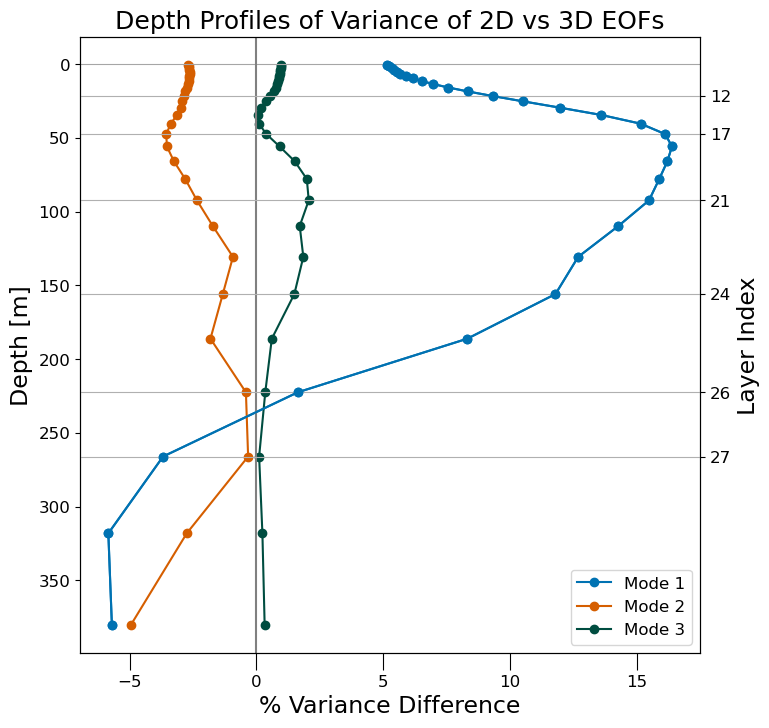

In [21]:
mode1diff = new[1].to_numpy()
mode2diff = new[2].to_numpy()
mode3diff = new[3].to_numpy()


# Create Fig, Ax
fig, ax1 = plt.subplots()


# Format 
fig.set_size_inches(8., 8.)
title_sz = 18
label_sz = title_sz - 1
tick_sz = title_sz -6

p1 = plt.plot(mode1diff[:30], depthLayer[:30], '#0072B2', marker = 'o', label = 'Mode 1')

p2 = plt.plot(mode2diff[:30], depthLayer[:30], "#D55E00", marker = "o", label = "Mode 2")
p3 = plt.plot(mode3diff[:30], depthLayer[:30], "#004D40", marker = "o", label = "Mode 3")

# Format X axis
ax1.set_xlabel("% Variance Difference", size = label_sz)
ax1.tick_params('x',size = tick_sz, labelsize = tick_sz)
#ax1.grid(axis = "x")


# Format Left hand y axis
ax1.set_ylabel('Depth [m]', size =label_sz)
step = 50                            # change this for smaller depth intervals
y_labels = ax1.get_yticks()
dep_names = np.arange(0,-y_labels[0],step).astype(int)
ax1.set_yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = tick_sz)
ax1.axhline(y = 0, color='0.65', linestyle='-', label='', lw = '0.8')


# Legend and Title
plt.legend(fontsize = tick_sz, loc = "lower right") 
plt.title("Depth Profiles of Variance of 2D vs 3D EOFs", size = title_sz)
#plt.title("2D DJF % Variance by Depth", size = title_sz)
plt.axvline(color = "grey")

# Create right hand y axis
ax2 = ax1.twinx()
ax2.plot(mode1diff[:30], depthLayer[:30], '#0072B2', marker = 'o')
dep_ind = np.arange(32).astype(str).tolist()



# Select based on depth of plot
indexLabels = [12, 17, 21, 24, 26, 27]  

layerIndex = depthLayer[indexLabels]
ax2.set_yticks(layerIndex, indexLabels, fontsize = tick_sz)
ax2.set_ylabel('Layer Index', size =label_sz)
ax2.grid(axis = "y")






saveName = 'D:/SCIL/Paper Figs/' + region + '/2D vs 3D Diff_400m.png'
plt.savefig(saveName, dpi=300, bbox_inches='tight')
plt.show()

In [83]:
mode3

[6.15437071563067,
 6.141752921904013,
 6.12571639883507,
 6.112060342188923,
 6.099488448080479,
 6.087099007047481,
 6.065226839026575,
 6.049451828626542,
 6.027988723132939,
 5.993956919289597,
 5.939793810287656,
 5.8523632591871575,
 5.724709192133751,
 5.557500731693908,
 5.370025987799419,
 5.233584967387617,
 5.270021845182934,
 5.561217110819827,
 6.081503903183152,
 6.680930191955929,
 7.15807427520867,
 7.234051981980539,
 6.87846107957578,
 7.020346010944291,
 6.666645083163929,
 5.777826410747994,
 5.519309568826718,
 5.277066043382959,
 5.406308373011265,
 5.494804939824645,
 5.299308452134459,
 4.898042612144769,
 4.837634252840494,
 5.007723044285688,
 5.221332994125234,
 5.023311058267426,
 4.871761910616904,
 5.0749860992387905,
 5.183678441120709,
 5.694005522555645,
 4.301128727877831,
 4.4079856951492635,
 4.365391708318897,
 4.466766639795349,
 4.796340712386876,
 5.459655503814832,
 6.574529490327667,
 6.997495855112549,
 8.85767686593757,
 nan]